<a href="https://colab.research.google.com/github/henriquepgomide/exp-curso-python-saude/blob/master/PySaude_03_python_arvore_regressao_projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/henriquepgomide/exp-curso-python-saude/master/assets/pucrs-logo.svg" width="300" align="center">

# **Auto ML**
---

Neste notebook, usaremos uma biblioteca low-code chamada Pycaret. Treinaremos um algoritmo que prediz qual a chance de um paciente de UTI morrer ao final da internação.

Para isso, usaremos dados sintéticos (gerados a partir de dados reais).

## Índice

* [Importando módulos](#imports)
* [1. Carregando os dados](#data)
* [2. Análise exploratória](#analysis)
* [3. AutoML](#tree)

## **Importando módulos** <a name="imports"></a>

A primeira coisa a ser feita é importar os módulos para termos as funcionalidades de trabalhar com os dados e construir os modelos.

Caso haja algum erro você pode consultar nosso [notebook sobre bibliotecas](https://github.com/zetta-health/exp-curso-python-saude/blob/master/PySaude_01_colab_visao_geral_03_bibliotecas.ipynb).

In [1]:
 #!pip install -q pycaret

In [2]:
# Trabalhar com os dados
import pandas as pd

# Criação e avaliação do modelo
from pycaret.classification import *

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Separar dados de treino e teste
from sklearn.model_selection import train_test_split

---

## **1. Carregando os dados** <a name="data"></a>

Agora vamos carregar nosso dataset! Esse banco de dados relaciona gastos de um plano de saúde com seus beneficiários com alguns atributos que podem impactar nesses gastos, como idade e sexo. 

Podemos utilizá-lo para criar um modelo que preverá os custos de um beneficiário que não esteja nesta base.

In [3]:
URL = 'https://raw.githubusercontent.com/henriquepgomide/exp-curso-python-saude/master/data/icu_simulated_data.parquet'

# EXERCICIO 01 [8 pontos]. Complete seu código abaixo para ler os dados da URL. Use a função 'pd.read_csv'.
df = pd.read_parquet(URL)

# EXERCICIO 02 [8 pontos]. Imprima os cinco primeiros casos.
df.tail()

,IE_SEXO_F,DS_CLINICA_CIRURGICA,IS_DEAD,NR_ANOS,FIRST_24H_QT_SATURACAO_O2_MEAN,FIRST_24H_QT_FREQ_CARDIACA_MEAN,FIRST_24H_QT_TEMP_MEAN,FIRST_24H_QT_PA_DIASTOLICA_MEAN,FIRST_24H_QT_PA_SISTOLICA_MEAN,FIRST_24H_QT_FREQ_RESP_MEAN
8284,0,0,1,51,88.762466,77.037460,35.421879,58.611290,91.507057,15.665819
4235,1,1,0,53,89.094940,69.615089,35.522194,56.914524,92.442238,15.461881
3007,0,1,0,51,87.588669,73.378471,35.439312,51.388302,86.169144,15.428762
4750,1,0,0,53,90.683563,68.961861,35.546944,58.216984,93.852394,15.554554
8914,1,1,0,56,87.687408,77.406525,35.571037,49.751556,86.862862,15.849882


In [4]:
# EXERCICIO 03 [8 pontos]. Quantos atributos (colunas) e quantas linhas existem no banco de dados?
df.shape

(500, 10)

In [5]:
df.columns

Index(['IE_SEXO_F', 'DS_CLINICA_CIRURGICA', 'IS_DEAD', 'NR_ANOS',
       'FIRST_24H_QT_SATURACAO_O2_MEAN', 'FIRST_24H_QT_FREQ_CARDIACA_MEAN',
       'FIRST_24H_QT_TEMP_MEAN', 'FIRST_24H_QT_PA_DIASTOLICA_MEAN',
       'FIRST_24H_QT_PA_SISTOLICA_MEAN', 'FIRST_24H_QT_FREQ_RESP_MEAN'],
      dtype='object')

---

## **2. Análise exploratória** <a name='analysis'></a>

Como vimos no nosso notebook de [análise exploratória](https://github.com/zetta-health/exp-curso-python-saude/blob/master/PySaude_03_python_analise_exploratoria_de_dados.ipynb), é bastante comum haver erros no preenchimento de alguns campos, como atributos com valores escritos de formas diferentes, ou atributos com valores ausentes.  


Além disso, é possível que os valores venham com os tipos de dados que precisam ser convertidos, por exemplo, às vezes números podem vir como _objects_ (_strings_).


Precisamos tratar desses problemas antes de realizar qualquer análise e construir algum modelo.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 113 to 8914
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IE_SEXO_F                        500 non-null    uint8  
 1   DS_CLINICA_CIRURGICA             500 non-null    uint8  
 2   IS_DEAD                          500 non-null    int64  
 3   NR_ANOS                          500 non-null    int64  
 4   FIRST_24H_QT_SATURACAO_O2_MEAN   500 non-null    float64
 5   FIRST_24H_QT_FREQ_CARDIACA_MEAN  500 non-null    float64
 6   FIRST_24H_QT_TEMP_MEAN           500 non-null    float64
 7   FIRST_24H_QT_PA_DIASTOLICA_MEAN  500 non-null    float64
 8   FIRST_24H_QT_PA_SISTOLICA_MEAN   500 non-null    float64
 9   FIRST_24H_QT_FREQ_RESP_MEAN      500 non-null    float64
dtypes: float64(6), int64(2), uint8(2)
memory usage: 36.1 KB


Vamos verificar os valores das colunas `sex`, `smoker` e `region`, que foram carregadas como `object`, ou seja, são categóricas. Isso significa que os valores podem ser letras, números, ou uma mistura dos dois.

Para começar, vamos visualizar a frequência dessas variáveis.

In [7]:
df['IE_SEXO_F'].value_counts()

1    255
0    245
Name: IE_SEXO_F, dtype: int64

In [8]:
df['IS_DEAD'].value_counts()

1    313
0    187
Name: IS_DEAD, dtype: int64

In [9]:
df['DS_CLINICA_CIRURGICA'].value_counts()

0    336
1    164
Name: DS_CLINICA_CIRURGICA, dtype: int64

Será preciso converter as variáveis `categóricas` em `numéricas`,  para podermos utilizá-las nos modelos.

Podemos facilitar a visualização dos dados usando gráficos.

### Idade dos participantes - histograma

<AxesSubplot:xlabel='FIRST_24H_QT_SATURACAO_O2_MEAN', ylabel='Count'>

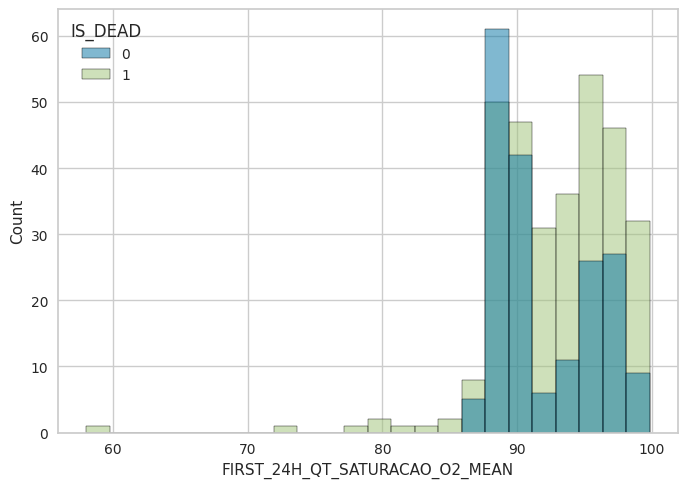

In [10]:
# EXERCICIO 04 [8 pontos]. Faça um histograma com o atributo 'age' (idade).
sns.histplot(data=df, x="FIRST_24H_QT_SATURACAO_O2_MEAN", hue="IS_DEAD")

### Distribuição por sexo - gráfico de barras

<AxesSubplot:>

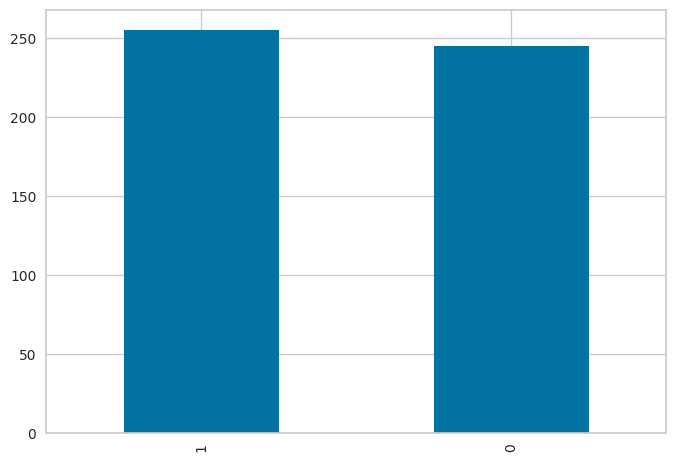

In [11]:
# EXERCICIO 05 [8 pontos]. Faça um gráfico de barras com o atributo 'sex' (sexo).
df["IE_SEXO_F"].value_counts().plot(kind="bar")

### Frequência cardíaca por desfecho - boxplot

In [12]:
# EXERCICIO 06 [8 pontos]. Faça um boxplot (caixas e bigodes) comparando a frequência cardíaca
# média nas primeiras 24 horas por desfecho (IS_DEAD)
# Este link pode ser útil: https://seaborn.pydata.org/generated/seaborn.boxplot.html


## **3. Auto-ML** <a name='tree'></a>

É hora de construir o modelo usando Pycaret, a biblioteca low-code para
aprendizado de máquina!

### a) Separar variáveis e desfecho (o que estamos tentando prever)

In [13]:
X = df.drop(columns=["IS_DEAD"])
y = df["IS_DEAD"]

### b) Separar banco de treino e teste

É comum dividirmos o banco de dados em um **banco de treino** e um **banco de teste**. Como os nomes sugerem, o banco de treino é usado para treinar o modelo e o banco de teste é usado para testarmos a habilidade preditiva do modelo.

In [14]:
# Separar banco de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

df_train = pd.merge(X_train, y_train, how="left", left_index=True, right_index=True)
df_test = pd.merge(X_test, y_test, how="left", left_index=True, right_index=True)

### c) Selecionar algoritmo e parâmetros, treinar modelo

In [15]:
classificador = setup(
    df_train, target="IS_DEAD", 
    session_id=1234, normalize=True, 
    categorical_features=["IE_SEXO_F", "DS_CLINICA_CIRURGICA"]
)

,Description,Value
0,session_id,1234
1,Target,IS_DEAD
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(404, 10)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
# Treinar modelos
compare_models(sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7054,0.7820,0.7484,0.7773,0.7578,0.3811,0.3908,0.3860
qda,Quadratic Discriminant Analysis,0.7270,0.7796,0.7078,0.8351,0.7636,0.4439,0.4549,0.0050
nb,Naive Bayes,0.7409,0.7780,0.6964,0.8690,0.7711,0.4800,0.4981,0.0050
lda,Linear Discriminant Analysis,0.6983,0.7756,0.7366,0.7747,0.7533,0.3656,0.3684,0.0040
lightgbm,Light Gradient Boosting Machine,0.6948,0.7709,0.7690,0.7529,0.7598,0.3390,0.3412,0.0110
gbc,Gradient Boosting Classifier,0.6948,0.7643,0.7582,0.7614,0.7583,0.3430,0.3457,0.0280
rf,Random Forest Classifier,0.6772,0.7622,0.7641,0.7338,0.7475,0.2997,0.3026,0.0760
et,Extra Trees Classifier,0.6984,0.7618,0.7807,0.7525,0.7648,0.3413,0.3451,0.0570
knn,K Neighbors Classifier,0.6881,0.7422,0.7307,0.7665,0.7453,0.3436,0.3486,0.0070
ada,Ada Boost Classifier,0.6804,0.7191,0.7520,0.7435,0.7465,0.3096,0.3121,0.0290


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
# Avaliar performance do modelo nos subconjuntos dos dados de treino
lr_model = create_model("lr", fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.8636,0.8333,0.8824,0.8571,0.6402,0.6419
1,0.6552,0.7576,0.7222,0.7222,0.7222,0.2677,0.2677
2,0.7857,0.8000,0.7778,0.8750,0.8235,0.5532,0.5594
3,0.7500,0.8778,0.7778,0.8235,0.8000,0.4674,0.4688
4,0.7143,0.7500,0.7222,0.8125,0.7647,0.4043,0.4088
5,0.5000,0.5611,0.4444,0.6667,0.5333,0.0392,0.0430
6,0.6786,0.7444,0.7222,0.7647,0.7429,0.3152,0.3161
7,0.6786,0.8667,0.7778,0.7368,0.7568,0.2841,0.2850
8,0.7857,0.8663,1.0000,0.7391,0.8500,0.5030,0.5796


[Validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html) (*cross-validation*) é um método muito usado para evitar o [sobreajuste](https://pt.wikipedia.org/wiki/Sobreajuste) (*overfitting*) do modelo. 

In [18]:
tuned_lr = tune_model(lr_model, optimize="AUC")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.8636,0.8333,0.8824,0.8571,0.6402,0.6419
1,0.6552,0.7525,0.7222,0.7222,0.7222,0.2677,0.2677
2,0.7857,0.8000,0.7778,0.8750,0.8235,0.5532,0.5594
3,0.7500,0.8722,0.7778,0.8235,0.8000,0.4674,0.4688
4,0.6786,0.7500,0.7222,0.7647,0.7429,0.3152,0.3161
5,0.5000,0.5667,0.4444,0.6667,0.5333,0.0392,0.0430
6,0.6786,0.7444,0.7222,0.7647,0.7429,0.3152,0.3161
7,0.6786,0.8667,0.7778,0.7368,0.7568,0.2841,0.2850
8,0.7857,0.8663,1.0000,0.7391,0.8500,0.5030,0.5796


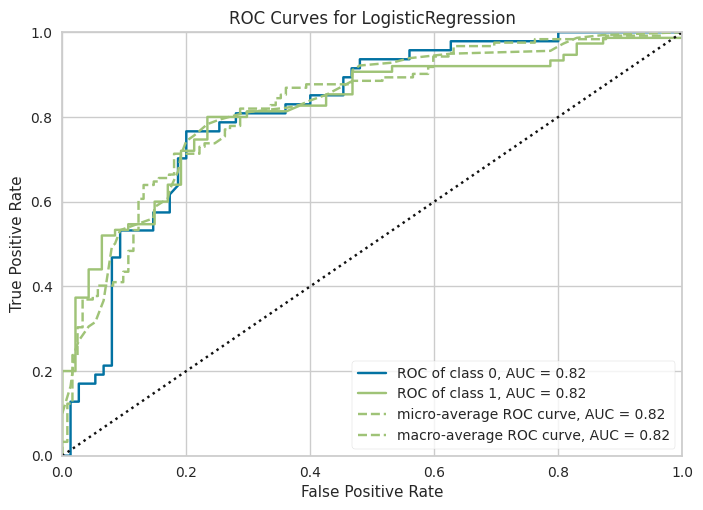

In [19]:
plot_model(tuned_lr)

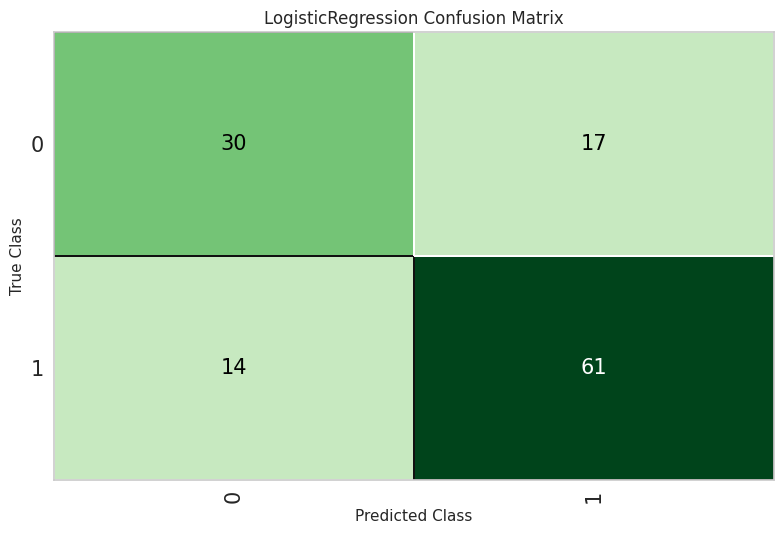

In [20]:
plot_model(tuned_lr, plot="confusion_matrix")

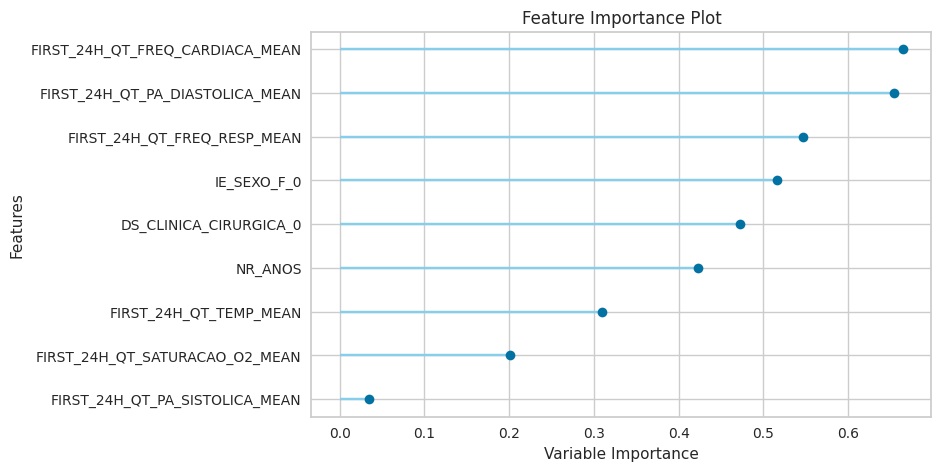

In [21]:
plot_model(tuned_lr, plot="feature")

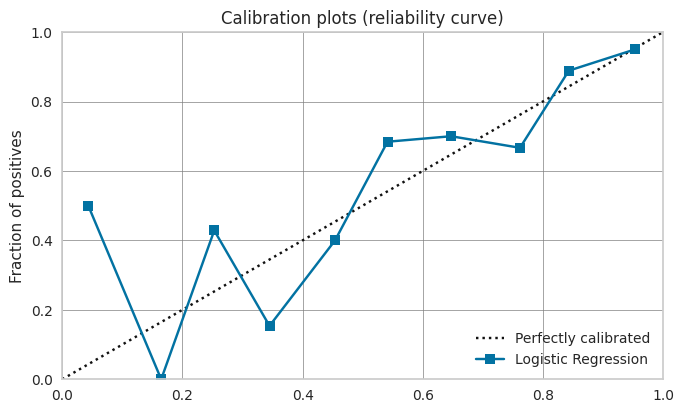

In [22]:
plot_model(tuned_lr, plot="calibration")

In [23]:
final_model = finalize_model(tuned_lr)

### d) Avaliar métricas do modelo

Nesse momento, comparamos as predições do nosso modelo com os casos reais do banco de teste. Isso nos permite avaliar o quão acuradas nossas predições são.

In [24]:
# Por fim, vamos gerar a árvore
predict_model(final_model, df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6900,0.8151,0.7937,0.7353,0.7634,0.3160,0.3179


,IE_SEXO_F,DS_CLINICA_CIRURGICA,NR_ANOS,FIRST_24H_QT_SATURACAO_O2_MEAN,FIRST_24H_QT_FREQ_CARDIACA_MEAN,FIRST_24H_QT_TEMP_MEAN,FIRST_24H_QT_PA_DIASTOLICA_MEAN,FIRST_24H_QT_PA_SISTOLICA_MEAN,FIRST_24H_QT_FREQ_RESP_MEAN,IS_DEAD,Label,Score
304,0,0,66,94.875000,94.250000,38.033333,85.375000,120.125000,25.500000,1,1,0.8654
317,1,1,54,92.666667,115.000000,35.466667,57.250000,90.000000,20.000000,1,1,0.9204
463,0,1,70,97.600000,81.800000,35.900000,84.600000,142.000000,16.000000,0,0,0.7856
155,1,0,93,89.916667,93.083333,35.727273,43.777778,87.555556,17.363636,1,1,0.9602
376,0,0,63,94.300000,55.400000,36.450000,64.500000,110.200000,19.600000,0,0,0.6431
...,...,...,...,...,...,...,...,...,...,...,...,...
472,1,1,38,98.000000,81.285714,36.600000,81.428571,123.000000,17.571429,0,0,0.7244
1082,0,1,60,90.700134,63.547890,35.798119,53.818871,92.553810,15.471916,0,0,0.7718
2485,1,1,52,87.883606,81.193802,35.438183,52.839806,84.254440,15.370520,0,1,0.5322
2531,1,0,62,89.231056,61.165833,35.730015,50.663536,89.854744,15.204265,0,1,0.5238


# **Yey! Parabéns por ter completado este notebook!**


Este notebook faz parte do curso de *Introdução ao Python para Gestão da Saúde*, ministrado por [Caio Salgado](https://www.linkedin.com/in/caio-salgado-b5758312/) e oferecido pela [Zetta Exponential](https://www.linkedin.com/company/zetta-health-analytics/) e Universidade Federal de Viçosa. Foi escrito por:

* [Ana Flávia Souza](https://www.linkedin.com/in/ana-fl%C3%A1via-souza-2b06151a5/): graduanda em Economia pela Universidade Federal de Viçosa e estagiária na Zetta Exponential.

* [Gabriel Kakizaki](https://www.linkedin.com/in/gabriel-kakizaki-25b6311a5/): graduando em Administração pela Universidade Federal de Viçosa, membro do PET-ADM e estagiário na Zetta Exponential.

Com supervisão de:

* [Dr. Henrique Gomide](https://www.linkedin.com/in/hpgomide/?originalSubdomain=br): líder do comitê científico da empresa Zetta Health e professor da Universidade Federal de Viçosa. 

--- 
Copyright 2020, Zetta Exponential


